#### The purpose of this notebook is to produce train and test data for the ML algorithm using template pulses

### Setup

In [2]:
import ROOT as r
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as skl
import pickle

Welcome to JupyROOT 6.18/04


In [3]:
# run this to make printing cleaner
np.set_printoptions(precision=None)

In [4]:
# set a seed if you want to make things repeatable
np.random.seed(420)

### Definitions

In [5]:
class Spline:
    """
    Take a root spline and make a cleaner object with two np arrays
    """
    def __init__(self, rSpline):
        spline = []
        times = []
        
        for i in np.linspace(rSpline.GetXmin(), rSpline.GetXmax(), rSpline.GetNpx()):
            spline.append(rSpline.Eval(i))
            times.append(i)

        self.spline = np.array(spline)
        self.times = np.array(times)
        
        self.samplingRate = times[2] - times[1]
        
    def peakTime(self):
        index = np.argmax(self.spline)
        return(self.times[index])

In [6]:
class Island:
    def __init__(self, nPulses=None, pulseEnergies=[], pulseTimes=[], noise=None, time=[], energy=[]):
        """
        nPulses: int, the number of pulses in this island
        pulseEnegies: np.array, the relative energies of each pulse
        pulseTimes: np.array, the time offset of each pulse
        noise: boolean, artificial noise off->false, on->true
        time: np.array, the time axis values
        energy: np.array, the energy axis values
        """
        
        self.nPulses = nPulses
        self.pulseEnergies = pulseEnergies
        self.pulseTimes = pulseTimes
        self.noise = noise
        self.time = time
        self.energy = energy
        
    def makeDF(self):
        d = {'time': self.time,
             'energy': self.energy}
        df = pd.DataFrame(data = d)
        return(df)

In [53]:
def digitize(thisIsland, theseTimes, samplingRateArtificial):
    
        sampledTimes = [theseTimes[0]]
    
        while(sampledTimes[-1] < [theseTimes[-1]]):
            sampledTimes.append(sampledTimes[-1] + samplingRateArtificial)
        
        theseSamples = np.interp(sampledTimes, theseTimes, thisIsland)
        
        thisIsland = np.array(theseSamples)
        theseTimes = np.array(sampledTimes)
        
        return thisIsland, theseTimes

In [54]:
def buildIsland(referenceSpline,
                minPulses = 0, maxPulses = 4,
                minEscale = 1, maxEscale=10,
                deltaTmin = 0, deltaTmax = 25,
                gainSag = None,
                verbosity = False,
                normalize = True,
                noise = False, noiseLevel = 0.001,
                nTailSamples = 150, randomizeTailLength = True,
                samplingRateArtificial=1.25):
    """
    Sets up a single randomized Island object
    """
    spline = referenceSpline.spline
    times = referenceSpline.times
    samplingRate = referenceSpline.samplingRate
    
    # figure out how many pulses there will be
    nPulses = np.random.randint(minPulses, maxPulses+1)
    if(verbosity): print(nPulses, "pulses in this island")
             
    # randomize the length of the tail samples
    if(randomizeTailLength):
        nTailSamples = nTailSamples + np.random.randint(-50, 100)
        if(verbosity): print(nTailSamples, "samples in this island")
            
    # define the y and t arrays that you see in the plot before filling them
    thisIsland = np.append(np.zeros_like(spline), np.zeros(nTailSamples))
    # the time array is the original one, plus however much else we want based on nTailSamples
    theseTimes = np.append(times, np.array([times[times.size-1] + samplingRate*i for i in range(1, nTailSamples+1)]))
    
        
    # if nPulses is zero, we already have what we want and can end it here
    if(nPulses == 0):
        
        thisIsland, theseTimes = digitize(thisIsland, theseTimes, samplingRateArtificial)
        
        if(noise):
            thisIsland += np.random.normal(0, noiseLevel, size=thisIsland.size)
            
        return Island(nPulses=nPulses, noise=noise, time=theseTimes, energy=thisIsland)
    
    # create the energy scaling values
    energyScaleFactors = np.random.uniform(minEscale, maxEscale, size=nPulses)
    if(verbosity): print("The energy scale factors are: {0}".format(energyScaleFactors))
    
    # create the time offsets
    timeOffsets = np.random.uniform(deltaTmin, deltaTmax, size=nPulses)
    if(verbosity): print("The time offsets are: {0}".format(timeOffsets))

    # put the pulses together into thisIsland
    for pulseIndex, deltaT in enumerate(timeOffsets):
        sample_offset = int(np.floor(deltaT))
        splineI = np.interp(times+deltaT-sample_offset, times, spline) * energyScaleFactors[pulseIndex]
        thisIsland[sample_offset:sample_offset + len(splineI)] += splineI
        
    # normalize if needed:
    if(normalize):
        thisIsland /= np.sum(thisIsland)
        
    # add digitization correction, interpolate to 1.25 ns by default
    if(samplingRateArtificial is not None):
        
        assert type(samplingRateArtificial) is float, print(
            """Error: Sampling rate must be a float.
            Currently {0}""".format(type(samplingRateArtificial)))
        
        if(verbosity):
            print(
            """Sampling this spline with a deltaT of {0} ns
            """.format(samplingRateArtificial) )
            
        thisIsland, theseTimes = digitize(thisIsland, theseTimes, samplingRateArtificial)
        
        
    # add gaussian noise to each sample
    if(noise):
        thisIsland += np.random.normal(0, noiseLevel, size=thisIsland.size)
            
        
    # now we are good to go
    return Island(nPulses=nPulses, pulseEnergies=energyScaleFactors, pulseTimes=timeOffsets,
                  noise=noise, time=theseTimes, energy=thisIsland)

### Make a single island for testing

0 pulses in this island


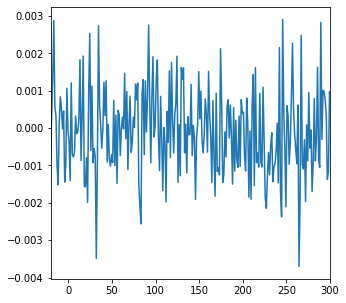

In [59]:
f = r.TFile("./calotemplate15.root")
spline0 = Spline(f.Get("masterSpline_xtal0"))

testIsland = buildIsland(referenceSpline=spline0,
                      verbosity=True, noise=True, randomizeTailLength=False)

fig, ax = plt.subplots(1,1);
fig.set_size_inches(5,5);

ax.plot(testIsland.time, testIsland.energy);
ax.set_xlim(-20, 300);

### Make a bunch of islands, and save them to x and y files for our ML

In [62]:
nIslands = 100000

f = r.TFile("./calotemplate15.root")

x = []
y = []

for index in range(0, nIslands+1):
    splineNum = np.random.randint(low=0, high=54)
    indexSpline = Spline(f.Get("masterSpline_xtal" + str(splineNum)))
    indexIsland = buildIsland(referenceSpline=indexSpline,
                              minPulses = 0, maxPulses = 4,
                              minEscale = 1, maxEscale=10,
                              deltaTmin = 0, deltaTmax = 25,
                              gainSag = None,
                              verbosity = False,
                              normalize = True,
                              noise = True, noiseLevel = 0.001,
                              nTailSamples = 150, randomizeTailLength = False)
    
    x.append([indexIsland.time, indexIsland.energy])
    y.append(indexIsland.nPulses)
    
with open('./template_data/set_3/x.data', 'wb') as xFile:
    pickle.dump(x, xFile)
    xFile.close()
with open('./template_data/set_3/y.data', 'wb') as yFile:
    pickle.dump(y, yFile)
    yFile.close()

Just a quick test that we actually got something:

In [61]:
with open('./template_data/set_2/x.data', 'rb') as xFile:
    x = pickle.load(xFile)
    for pair in x[:100]:
        print(len(pair[0]))
    xFile.close()

404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
